# Student dropout prediction and recommendations algorithm

# 1-Load Libraries and Dataset

In [22]:
#test
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load dataset
# Assuming your CSV has columns:
# ACT, SAT, Parental_education, Parental_income, HighSchool_GPA, College_GPA, Years_to_graduate, Dropout
df = pd.read_csv("../data/raw/graduation_rate.csv")
df.head()


,ACT composite score,SAT total score,parental level of education,parental income,high school gpa,college gpa,years to graduate
0,22,1625,high school,40999,3.0,3.1,7
1,29,2090,associate's degree,75817,4.0,3.4,5
2,30,2188,bachelor's degree,82888,4.0,3.9,3
3,33,2151,associate's degree,93518,4.0,3.7,5
4,29,2050,associate's degree,79153,4.0,3.4,6


# 2-Explore Data

       ACT composite score  SAT total score  parental income  high school gpa  \
count          1000.000000      1000.000000       1000.00000      1000.000000   
mean             28.607000      1999.906000      67377.85200         3.707400   
std               2.774211       145.078361      18827.33105         0.287381   
min              20.000000      1598.000000      18906.00000         2.800000   
25%              27.000000      1898.000000      54269.75000         3.500000   
50%              28.500000      2000.000000      67842.50000         3.800000   
75%              31.000000      2099.000000      80465.50000         4.000000   
max              36.000000      2385.000000     124470.00000         4.000000   

       college gpa  years to graduate  
count  1000.000000        1000.000000  
mean      3.376500           4.982000  
std       0.237179           1.414099  
min       2.600000           3.000000  
25%       3.200000           4.000000  
50%       3.400000           5

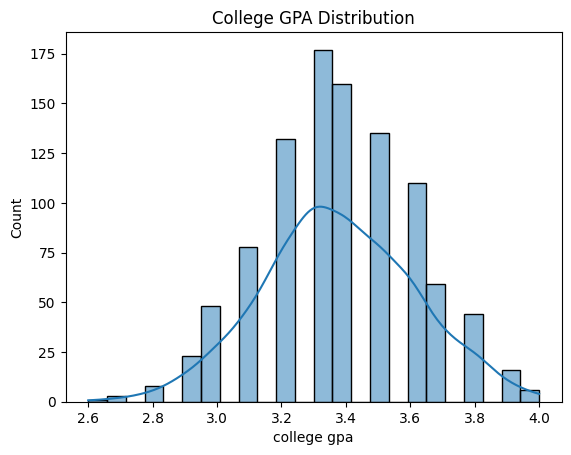

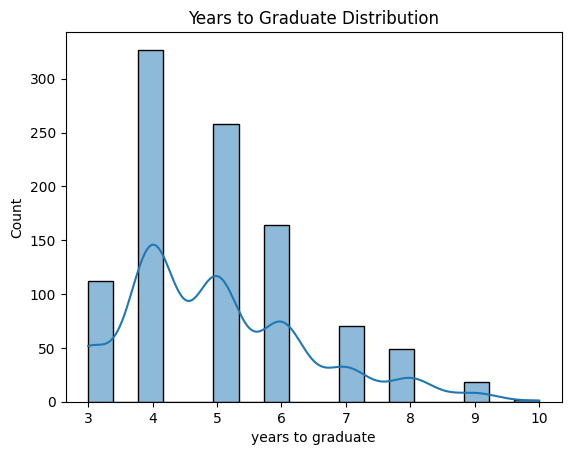

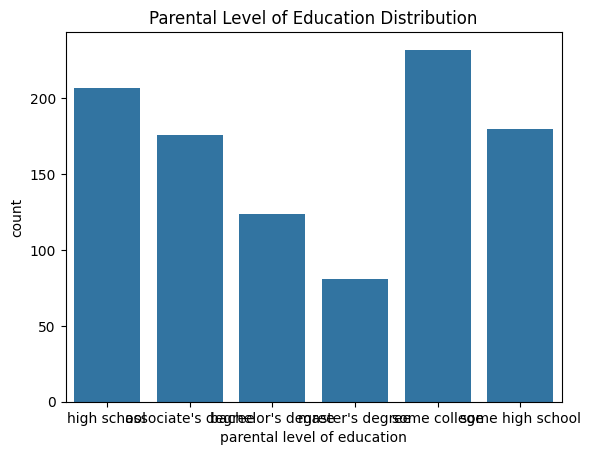

In [23]:
# Basic data exploration
print(df.describe())
print(df.info())

# Check for missing values
print(df.isnull().sum())

# For simplicity, drop rows with missing values (you can also handle them more gracefully with imputation)
df = df.dropna()

# Visualizing some basic distributions
sns.histplot(df['college gpa'], kde=True)
plt.title("College GPA Distribution")
plt.show()

sns.histplot(df['years to graduate'], kde=True)
plt.title("Years to Graduate Distribution")
plt.show()

sns.countplot(x='parental level of education', data=df)
plt.title("Parental Level of Education Distribution")
plt.show()


# 3- Target Variable (at risk of fail or drop off)
since the data set does not include dropoff rate , I wiill create a target to classify students based on:\n
    *college gpa - where below 2 is at risk of dropping off or not meeting graduating requirements\n
    *years to graduate - where over 4 is at risk of dropping off

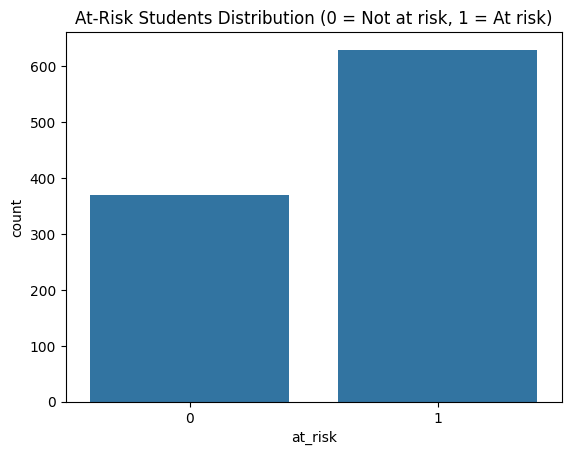

,ACT composite score,SAT total score,parental level of education,parental income,high school gpa,college gpa,years to graduate,at_risk
0,22,1625,high school,40999,3.0,3.1,7,1
1,29,2090,associate's degree,75817,4.0,3.4,5,1
2,30,2188,bachelor's degree,82888,4.0,3.9,3,0
3,33,2151,associate's degree,93518,4.0,3.7,5,0
4,29,2050,associate's degree,79153,4.0,3.4,6,1


In [ ]:
# Create a binary target variable 'at_risk'
df['at_risk'] = np.where((df['college gpa'] < 2.5) | (df['highschool gpa'] < 3.5), 1, 0)

# Check the balance of our new target variable
sns.countplot(x='at_risk', data=df)
plt.title("At-Risk Students Distribution (0 = Not at risk, 1 = At risk)")
plt.show()

# Show first few rows with the new target column
df.head()


# 4- Feature Engineering

In [25]:
# Encode 'Parental_level_of_education'
le = LabelEncoder()
df['Parental_education_encoded'] = le.fit_transform(df['parental level of education'])

# Features and target
features = ['ACT composite score', 'SAT total score', 'Parental_education_encoded', 'parental income', 'high school gpa', 'college gpa', 'years to graduate']
X = df[features]
y = df['at_risk']

# Scale numeric features (ACT, SAT, GPA, etc.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Random Forest Model Training

Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       1.00      1.00      1.00       132

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



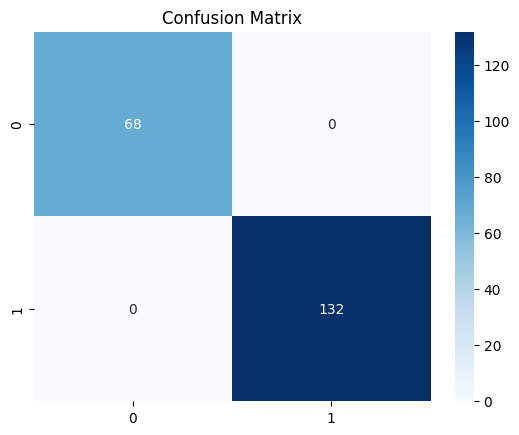

In [26]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Predict Risk for New Students

In [27]:
# Function to predict dropout risk for a new student profile
def predict_risk(student_profile):

    df_input = pd.DataFrame([student_profile])
    df_input['Parental_education_encoded'] = le.transform(df_input['parental level of education'])
    print(features)
    df_input = df_input[features]
    df_scaled = scaler.transform(df_input)
    
    # Predict dropout risk
    dropout_prob = rf.predict_proba(df_scaled)[0][1]
    prediction = rf.predict(df_scaled)[0]
    
    return {'Dropout_Probability': dropout_prob, 'Prediction': prediction}

# Example student
student_profile = {
    'ACT composite score': 26,
    'SAT total score': 1300,
    'Parental_level_of_education': 'High School',
    'Parental_income': 40000,
    'High school GPA': 3.0,
    'College_GPA': 1.9,
    'Years_to_graduate': 5
}
row = df.iloc[1]
predict_risk(row)


['ACT composite score', 'SAT total score', 'Parental_education_encoded', 'parental income', 'high school gpa', 'college gpa', 'years to graduate']


{'Dropout_Probability': np.float64(0.985), 'Prediction': np.int64(1)}

# Generate recoommendation for at risk

In [28]:
# Generate simple interventions
def generate_interventions(row):
    interventions = []
    if row['college gpa'] < 2.5:
        interventions.append("Enroll in tutoring programs")
    if row['years to graduate'] > 4:
        interventions.append("Consider taking fewer credits or improving time management")
    if row['ACT composite score'] < 25 or row['SAT total score'] < 1100:
        interventions.append("Seek academic counseling for course selection")
    return interventions

# Add recommendations to top at-risk students
top_risk_students = df.sort_values('at_risk', ascending=False).head(10)
top_risk_students['Recommendations'] = top_risk_students.apply(generate_interventions, axis=1)

top_risk_students[['ACT composite score', 'SAT total score', 'college gpa', 'at_risk', 'Recommendations']]


,ACT composite score,SAT total score,college gpa,at_risk,Recommendations
998,32,2034,3.2,1,[Consider taking fewer credits or improving ti...
0,22,1625,3.1,1,[Consider taking fewer credits or improving ti...
1,29,2090,3.4,1,[Consider taking fewer credits or improving ti...
996,27,1930,3.2,1,[]
979,29,2006,3.2,1,[Consider taking fewer credits or improving ti...
978,25,1786,3.1,1,[Consider taking fewer credits or improving ti...
977,29,1938,3.4,1,[Consider taking fewer credits or improving ti...
976,28,2068,3.4,1,[Consider taking fewer credits or improving ti...
974,29,2137,2.8,1,[Consider taking fewer credits or improving ti...
971,28,1900,3.4,1,[]


# Save the model

In [29]:
import joblib

# Save the model and preprocessing steps
joblib.dump(rf, "dropout_prediction_rf_model.pkl")
joblib.dump(scaler, "dropout_prediction_scaler.pkl")
joblib.dump(le, "parental_education_encoder.pkl")


['parental_education_encoder.pkl']

# AI to predict

In [30]:
import joblib

# Load the model, scaler, and encoder
rf_loaded = joblib.load("dropout_prediction_rf_model.pkl")
scaler_loaded = joblib.load("dropout_prediction_scaler.pkl")
le_loaded = joblib.load("parental_education_encoder.pkl")

# Now, you can use the loaded model, scaler, and encoder as needed
# sample student profile
student_profile = {
    'ACT composite score': 26,
    'SAT total score': 1300,
    'parental level of education': 'high school',
    'parental income': 40000,
    'high school gpa': 3.0,
    'college gpa': 1.9,
    'years to graduate': 5
}

# Convert the student profile into a DataFrame
df_input = pd.DataFrame([student_profile])

# Encode the 'Parental_level_of_education' column using the loaded encoder
df_input['Parental_education_encoded'] = le_loaded.transform(df_input['parental level of education'])

# Scale the features using the loaded scaler
df_scaled = scaler_loaded.transform(df_input[features])

# Make a prediction using the loaded model
dropout_prob = rf_loaded.predict_proba(df_scaled)[0][1]
prediction = rf_loaded.predict(df_scaled)[0]

print(f"Dropout Probability: {dropout_prob}")
print(f"Prediction: {prediction}")


Dropout Probability: 0.995
Prediction: 1


# GUI

In [31]:
import tkinter as tk
from tkinter import messagebox
import joblib
import pandas as pd

# Load the model, scaler, and encoder
rf_loaded = joblib.load("dropout_prediction_rf_model.pkl")
scaler_loaded = joblib.load("dropout_prediction_scaler.pkl")
le_loaded = joblib.load("parental_education_encoder.pkl")


# Create the Tkinter window
root = tk.Tk()
root.title("Student Dropout Prediction")

# Create a function to handle the prediction
def predict_dropout():
    try:
        # Get data from the input fields
        act_score = float(act_score_entry.get())
        sat_score = float(sat_score_entry.get())
        parental_education = parental_education_entry.get()
        parental_income = float(parental_income_entry.get())
        high_school_gpa = float(high_school_gpa_entry.get())
        college_gpa = float(college_gpa_entry.get())
        years_to_graduate = float(years_to_graduate_entry.get())
        
        # Prepare the student profile dictionary
        student_profile = {
            'ACT composite score': act_score,
            'SAT total score': sat_score,
            'parental level of education': parental_education,  # Correct column name
            'parental income': parental_income,
            'high school gpa': high_school_gpa,
            'college gpa': college_gpa,
            'years to graduate': years_to_graduate
        }

        # Convert the student profile into a DataFrame
        df_input = pd.DataFrame([student_profile])

        # Encode the 'parental level of education' column using the loaded encoder
        df_input['Parental_education_encoded'] = le_loaded.transform(df_input['parental level of education'])

        # Debug: Check the transformed input data
        print(f"Transformed data for prediction:\n{df_input}")

        # Scale the features using the loaded scaler
        df_scaled = scaler_loaded.transform(df_input[features])

        # Debug: Check scaled data
        print(f"Scaled data:\n{df_scaled}")

        # Make a prediction using the loaded model
        dropout_prob = rf_loaded.predict_proba(df_scaled)[0][1]
        prediction = rf_loaded.predict(df_scaled)[0]

        # Show the result in the GUI
        messagebox.showinfo("Prediction Result", 
                            f"Dropout Probability: {dropout_prob:.2f}\nPrediction: {'Dropout' if prediction == 1 else 'No Dropout'}")

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Create the form labels and input fields
tk.Label(root, text="ACT Composite Score:").grid(row=0, column=0)
act_score_entry = tk.Entry(root)
act_score_entry.grid(row=0, column=1)

tk.Label(root, text="SAT Total Score:").grid(row=1, column=0)
sat_score_entry = tk.Entry(root)
sat_score_entry.grid(row=1, column=1)

tk.Label(root, text="Parental Level of Education:").grid(row=2, column=0)
parental_education_entry = tk.Entry(root)
parental_education_entry.grid(row=2, column=1)

tk.Label(root, text="Parental Income:").grid(row=3, column=0)
parental_income_entry = tk.Entry(root)
parental_income_entry.grid(row=3, column=1)

tk.Label(root, text="High School GPA:").grid(row=4, column=0)
high_school_gpa_entry = tk.Entry(root)
high_school_gpa_entry.grid(row=4, column=1)

tk.Label(root, text="College GPA:").grid(row=5, column=0)
college_gpa_entry = tk.Entry(root)
college_gpa_entry.grid(row=5, column=1)

tk.Label(root, text="Years to Graduate:").grid(row=6, column=0)
years_to_graduate_entry = tk.Entry(root)
years_to_graduate_entry.grid(row=6, column=1)

# Create the "Predict" button
predict_button = tk.Button(root, text="Predict Dropout Risk", command=predict_dropout)
predict_button.grid(row=7, column=0, columnspan=2)

# Run the Tkinter event loop
root.mainloop()


# DELED later

In [32]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import joblib
import pandas as pd

# Load the model, scaler, and encoder
rf_loaded = joblib.load("dropout_prediction_rf_model.pkl")
scaler_loaded = joblib.load("dropout_prediction_scaler.pkl")
le_loaded = joblib.load("parental_education_encoder.pkl")

# Create the Tkinter window
root = tk.Tk()
root.title("Student Dropout Prediction")
root.geometry("400x400")  # Adjust the window size

# Define the available parental education levels for the dropdown
parental_education_levels = ["high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]

# Create a function to handle the prediction
def predict_dropout():
    try:
        # Get data from the input fields
        act_score = act_score_slider.get()
        sat_score = sat_score_slider.get()
        parental_education = parental_education_combo.get()
        parental_income = float(parental_income_entry.get())
        high_school_gpa = high_school_gpa_slider.get()
        college_gpa = college_gpa_slider.get()
        years_to_graduate = years_to_graduate_slider.get()
        
        # Prepare the student profile dictionary
        student_profile = {
            'ACT composite score': act_score,
            'SAT total score': sat_score,
            'parental level of education': parental_education,  # Correct column name
            'parental income': parental_income,
            'high school gpa': high_school_gpa,
            'college gpa': college_gpa,
            'years to graduate': years_to_graduate
        }

        # Convert the student profile into a DataFrame
        df_input = pd.DataFrame([student_profile]) 

        # Encode the 'parental level of education' column using the loaded encoder
        df_input['Parental_education_encoded'] = le_loaded.transform(df_input['parental level of education'])

        # Debug: Check the transformed input data
        print(f"Transformed data for prediction:\n{df_input}")

        # Scale the features using the loaded scaler
        df_scaled = scaler_loaded.transform(df_input[features])

        # Debug: Check scaled data
        print(f"Scaled data:\n{df_scaled}")

        # Make a prediction using the loaded model
        dropout_prob = rf_loaded.predict_proba(df_scaled)[0][1]
        prediction = rf_loaded.predict(df_scaled)[0]

        # Show the result in the GUI
        messagebox.showinfo("Prediction Result", 
                            f"Dropout Probability: {dropout_prob:.2f}\nPrediction: {'Dropout' if prediction == 1 else 'No Dropout'}")

    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")


# ACT Composite Score (Slider)
tk.Label(root, text="ACT Composite Score:").grid(row=0, column=0, padx=10, pady=5)
act_score_slider = tk.Scale(root, from_=0, to=36, orient='horizontal')
act_score_slider.grid(row=0, column=1)

# SAT Total Score (Slider)
tk.Label(root, text="SAT Total Score:").grid(row=1, column=0, padx=10, pady=5)
sat_score_slider = tk.Scale(root, from_=400, to=1600, orient='horizontal')
sat_score_slider.grid(row=1, column=1)

# Parental Level of Education (Dropdown)
tk.Label(root, text="Parental Level of Education:").grid(row=2, column=0, padx=10, pady=5)
parental_education_combo = ttk.Combobox(root, values=parental_education_levels)
parental_education_combo.grid(row=2, column=1)
parental_education_combo.set(parental_education_levels[0])  # Set default value

# Parental Income (Text entry)
tk.Label(root, text="Parental Income:").grid(row=3, column=0, padx=10, pady=5)
parental_income_entry = tk.Entry(root)
parental_income_entry.grid(row=3, column=1)

# High School GPA (Slider)
tk.Label(root, text="High School GPA:").grid(row=4, column=0, padx=10, pady=5)
high_school_gpa_slider = tk.Scale(root, from_=0.0, to=4.0, resolution=0.1, orient='horizontal')
high_school_gpa_slider.grid(row=4, column=1)

# College GPA (Slider)
tk.Label(root, text="College GPA:").grid(row=5, column=0, padx=10, pady=5)
college_gpa_slider = tk.Scale(root, from_=0.0, to=4.0, resolution=0.1, orient='horizontal')
college_gpa_slider.grid(row=5, column=1)

# Years to Graduate (Slider)
tk.Label(root, text="Years to Graduate:").grid(row=6, column=0, padx=10, pady=5)
years_to_graduate_slider = tk.Scale(root, from_=1, to=6, orient='horizontal')
years_to_graduate_slider.grid(row=6, column=1)

# Create the "Predict" button
predict_button = tk.Button(root, text="Predict Dropout Risk", command=predict_dropout)
predict_button.grid(row=7, column=0, columnspan=2, pady=10)

# Run the Tkinter event loop
root.mainloop()


Transformed data for prediction:
   ACT composite score  SAT total score parental level of education  \
0                    0              400                 high school   

   parental income  high school gpa  college gpa  years to graduate  \
0          50000.0              0.0          0.0                  1   

   Parental_education_encoded  
0                           2  
Scaled data:
[[-10.31692008 -11.03339285  -0.34666577  -0.92347383 -12.90710014
  -14.24319073  -2.81733655]]
Transformed data for prediction:
   ACT composite score  SAT total score parental level of education  \
0                    0              400                 high school   

   parental income  high school gpa  college gpa  years to graduate  \
0          50000.0              2.3          0.9                  1   

   Parental_education_encoded  
0                           2  
Scaled data:
[[-10.31692008 -11.03339285  -0.34666577  -0.92347383  -4.89978226
  -10.44669387  -2.81733655]]
Transformed da

KeyboardInterrupt: 